# Import important libraries

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
# The majority of the following codes have been borrowed and modified from MIE1513

In [0]:
from zipfile import ZipFile 

In [0]:
file_name = "ml-100k.zip"

In [0]:
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
ml-100k/                                       2016-01-29 14:26:28            0
ml-100k/allbut.pl                              2000-07-19 16:09:28          716
ml-100k/mku.sh                                 2000-07-19 16:09:28          643
ml-100k/README                                 2016-01-29 14:26:28         6750
ml-100k/u.data                                 2000-07-19 16:09:30      1979173
ml-100k/u.genre                                2000-07-19 16:09:30          202
ml-100k/u.info                                 2000-07-19 16:09:30           36
ml-100k/u.item                                 2000-07-19 16:09:30       236344
ml-100k/u.occupation                           2000-07-19 16:09:30          193
ml-100k/u.user                                 2000-07-19 16:09:30        22628
ml-100k/u1.base                                2001-03-08 12:33:08      1586544
ml-100k/u1.test                         

In [0]:
MOVIELENS_DIR = "ml-100k"

# Read MovieLens Data

### Define getData function to read the corrsponding dataframe

In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data') 

In [0]:
rating_df.tail()

,userID,itemID,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [0]:
rating_df.shape

(100000, 4)

### Data Exploration

In [0]:
rating_number = rating_df.drop(['timestamp','itemID'],axis=1)
rating_number = rating_number.groupby('userID')['rating'].count().reset_index()

Text(0, 0.5, '# of ratings ')

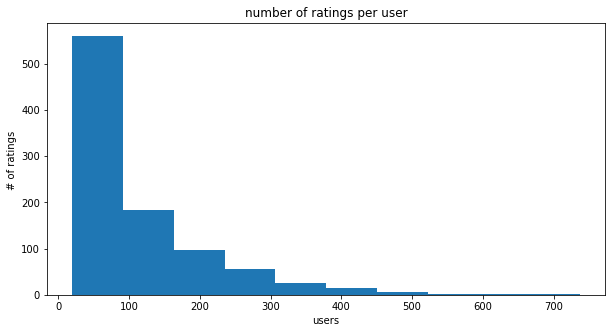

In [0]:
plt.figure(figsize=(10,5))
plot = plt.hist(rating_number['rating'])
plt.title('number of ratings per user')
plt.xlabel('users')
plt.ylabel('# of ratings ')

### Check the number of uers and number of items

In [0]:
numUsers = len(rating_df.userID.unique())
numItems = len(rating_df.itemID.unique())
print("Number of users:", numUsers)
print("Number of items:", numItems)

Number of users: 943
Number of items: 1682


# Build User Item Matrix for further analysis.
<p>The shape of the matrix is UxI

In [0]:
def buildUserItemMatrix(dataset, numUsers, numItems):
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((numUsers, numItems), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in dataset.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

### Split the data into train and test data, then append them into folds for cross validation.

In [0]:
# use u1 to u6 as the folds of cross validation, read them as csv file
folds = []
data_types = ['u{0}.base','u{0}.test']
for i in range(1,6):
    train_set = getData(MOVIELENS_DIR, data_types[0].format(i))
    test_set = getData(MOVIELENS_DIR, data_types[1].format(i))
    folds.append([train_set, test_set])

In [0]:
#def kNearestNeighbor(sim, k):
#    sim_matrix = sim_matrix.copy()
#    m,n = sim_matrix.shape
#    for i in range(m):
        # only keep the k largest number
#        sim_matrix[i, sim_matrix[i].argsort()[:-k]] = 0
#    return sim_matrix

# User-User Collaborative Filtering

In [0]:
def user_user_RecSys(trainSet, knn=None):
    temp_matrix = np.zeros(trainSet.shape)
    temp_matrix[trainSet.nonzero()] = 1

    uu_similarity = 1 - pairwise_distances(trainSet, metric='cosine')
    if knn is not None:
        uu_similarity = uu_similarity.copy()
        m,n = uu_similarity.shape
        for i in range(m):
        # only keep the k largest number
            uu_similarity[i, uu_similarity[i].argsort()[:-knn]] = 0
            
    normalizer = np.matmul(uu_similarity, temp_matrix)
    normalizer[normalizer == 0] = 1e-5
    
    predictionMatrix = np.matmul(uu_similarity, trainSet)/normalizer
    
    return predictionMatrix

In [0]:
def rmse(pred, test):
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
from numpy import mean
number_of_k = [20,30,40,50, 60, 70, 80]
scores= []
fold_average = []
for i in number_of_k:
    fold_scores = []
    
    for fold in folds:
        userSimPrediction = user_user_RecSys(buildUserItemMatrix(fold[0], numUsers, numItems), knn=i)  #(Tune this k to use differnt k value for knn)
        fold_scores.append(rmse(userSimPrediction, buildUserItemMatrix(fold[1], numUsers, numItems))) #(can add a for loop to do hyperparameter tuning)
    print('With {} nearest neightbour, the fold scores are{}'.format(i,fold_scores))    
    scores.append(fold_scores)
    fold_average.append(mean(fold_scores))
#buildUserItemMatrix is to turn dataframe into user-item matrix
#can ignore the warnings by import warning, similar like 1624, logisticRegression.ipynb, they used ignore warnings as well

With 20 nearest neightbour, the fold scores are[1.2793447692024946, 1.2771940669420847, 1.2608178195797883, 1.2513253992890154, 1.269111124932971]
With 30 nearest neightbour, the fold scores are[1.19260659398186, 1.1831531264550263, 1.1773371348793586, 1.167157326744175, 1.1682370596496723]
With 40 nearest neightbour, the fold scores are[1.150449679293232, 1.1351900438291225, 1.135166968885256, 1.1253537049042905, 1.1248286368803817]
With 50 nearest neightbour, the fold scores are[1.1183824715858848, 1.1073323473824659, 1.108372966020668, 1.0965619630353436, 1.1024410946712924]
With 60 nearest neightbour, the fold scores are[1.0977642955079794, 1.0879639964581005, 1.0873102392378713, 1.0742267107956307, 1.0858432313188326]
With 70 nearest neightbour, the fold scores are[1.0806840133993856, 1.0719983345326283, 1.074812634448114, 1.0644683700769881, 1.0747515894952655]
With 80 nearest neightbour, the fold scores are[1.0721759390248053, 1.0597485706205472, 1.0676306867419263, 1.0522501675

In [0]:
scores

[[1.2793447692024946,
  1.2771940669420847,
  1.2608178195797883,
  1.2513253992890154,
  1.269111124932971],
 [1.19260659398186,
  1.1831531264550263,
  1.1773371348793586,
  1.167157326744175,
  1.1682370596496723],
 [1.150449679293232,
  1.1351900438291225,
  1.135166968885256,
  1.1253537049042905,
  1.1248286368803817],
 [1.1183824715858848,
  1.1073323473824659,
  1.108372966020668,
  1.0965619630353436,
  1.1024410946712924],
 [1.0977642955079794,
  1.0879639964581005,
  1.0873102392378713,
  1.0742267107956307,
  1.0858432313188326],
 [1.0806840133993856,
  1.0719983345326283,
  1.074812634448114,
  1.0644683700769881,
  1.0747515894952655],
 [1.0721759390248053,
  1.0597485706205472,
  1.0676306867419263,
  1.052250167547115,
  1.0656538675755087]]

In [0]:
fold_average

[1.2675586359892708,
 1.1776982483420186,
 1.1341978067584566,
 1.106618168539131,
 1.0866216946636829,
 1.0733429883904761,
 1.0634918463019805]

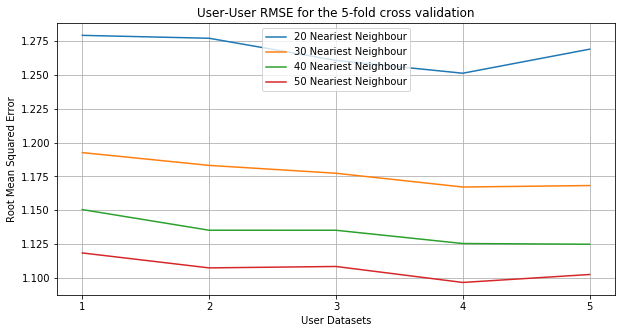

In [0]:
plt.figure(figsize=(10,5))
plt.plot(range(1,6),scores[0])
plt.plot(range(1,6),scores[1])
plt.plot(range(1,6),scores[2])
plt.plot(range(1,6),scores[3])

plt.legend(["20 Neariest Neighbour","30 Neariest Neighbour","40 Neariest Neighbour","50 Neariest Neighbour"], loc = 'top_right')

plt.xticks(range(1,6,1))
plt.ylabel("Root Mean Squared Error")
plt.title("User-User RMSE for the 5-fold cross validation")
plt.xlabel("User Datasets")
plt.grid()
plt.show()

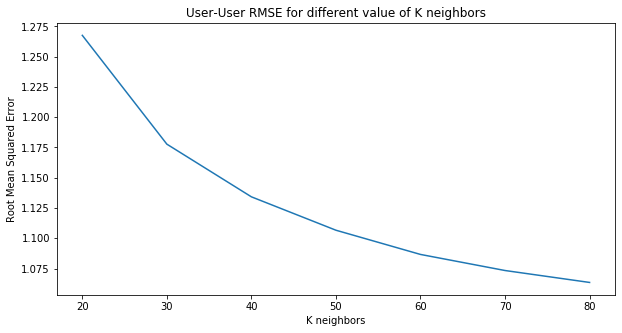

In [0]:
plt.figure(figsize=(10,5))
plt.plot(number_of_k,fold_average)
plt.ylabel("Root Mean Squared Error")
plt.title("User-User RMSE for different value of K neighbors")
plt.xlabel("K neighbors")
plt.show()

# Item-Item Collaborative Filtering

In [0]:
def item_item_RecSys(trainSet, knn=None):
    trainSet = trainSet.transpose()
    temp_matrix = np.zeros(trainSet.shape)
    temp_matrix[trainSet.nonzero()] = 1

    ii_similarity = 1 - pairwise_distances(trainSet, metric='cosine')
    if knn is not None:
        ii_similarity = ii_similarity.copy()
        m,n = ii_similarity.shape
        for i in range(m):
        # only keep the k largest number
            ii_similarity[i, ii_similarity[i].argsort()[:-knn]] = 0
            
    normalizer = np.matmul(ii_similarity, temp_matrix)
    normalizer[normalizer == 0] = 1e-5
    
    predictionMatrix = np.matmul(ii_similarity, trainSet)/normalizer
    
    return predictionMatrix.transpose()

In [0]:

number_of_k = [20,30,40,50, 60, 70, 80]
scores= []
fold_average = []
for i in number_of_k:
    fold_scores = []
    
    for fold in folds:
        itemSimPrediction = item_item_RecSys(buildUserItemMatrix(fold[0], numUsers, numItems), knn=i)  #(Tune this k to use differnt k value for knn)
        fold_scores.append(rmse(itemSimPrediction, buildUserItemMatrix(fold[1], numUsers, numItems))) #(can add a for loop to do hyperparameter tuning)
    print('With {} nearest neightbour, the fold scores are{}'.format(i,fold_scores))    
    scores.append(fold_scores)
    fold_average.append(mean(fold_scores))
#buildUserItemMatrix is to turn dataframe into user-item matrix
#can ignore the warnings by import warning, similar like 1624, logisticRegression.ipynb, they used ignore warnings as well
#buildUserItemMatrix is to trun dataframe into user-item matrix
#can ignore the warnings by import warning, similar like 1624, logisticRegression.ipynb, they used ignore warnings as well

With 20 nearest neightbour, the fold scores are[1.3073730793393332, 1.214940922817544, 1.2065892482429352, 1.2171506815714723, 1.2694137718031229]
With 30 nearest neightbour, the fold scores are[1.1930162473598438, 1.1246842526445995, 1.116356934841176, 1.1321768141520905, 1.1556496696159184]
With 40 nearest neightbour, the fold scores are[1.131667256642828, 1.078461624039943, 1.0661251811016006, 1.0810100166184553, 1.098788886706028]
With 50 nearest neightbour, the fold scores are[1.0922257537991578, 1.0475723757217443, 1.035537329890477, 1.0603317678714925, 1.0624102553971757]
With 60 nearest neightbour, the fold scores are[1.0755327566061044, 1.02672059965092, 1.0182775204132803, 1.0374579414350342, 1.0395058283280072]
With 70 nearest neightbour, the fold scores are[1.0537615701023275, 1.013667861774278, 1.0079958431711333, 1.0233650908879492, 1.0262608644321132]
With 80 nearest neightbour, the fold scores are[1.0371537944263396, 1.0038334005857845, 0.9972886403560537, 1.01104820226

In [0]:
scores

[[1.3073730793393332,
  1.214940922817544,
  1.2065892482429352,
  1.2171506815714723,
  1.2694137718031229],
 [1.1930162473598438,
  1.1246842526445995,
  1.116356934841176,
  1.1321768141520905,
  1.1556496696159184],
 [1.131667256642828,
  1.078461624039943,
  1.0661251811016006,
  1.0810100166184553,
  1.098788886706028],
 [1.0922257537991578,
  1.0475723757217443,
  1.035537329890477,
  1.0603317678714925,
  1.0624102553971757],
 [1.0755327566061044,
  1.02672059965092,
  1.0182775204132803,
  1.0374579414350342,
  1.0395058283280072],
 [1.0537615701023275,
  1.013667861774278,
  1.0079958431711333,
  1.0233650908879492,
  1.0262608644321132],
 [1.0371537944263396,
  1.0038334005857845,
  0.9972886403560537,
  1.0110482022606442,
  1.0153787417593052]]

In [0]:
fold_average

[1.2430935407548815,
 1.1443767837227257,
 1.091210593021771,
 1.0596154965360096,
 1.0394989292866694,
 1.0250102460735602,
 1.0129405558776257]

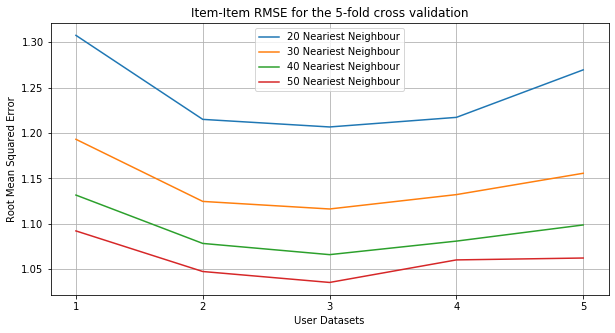

In [0]:
plt.figure(figsize=(10,5))
plt.plot(range(1,6),scores[0])
plt.plot(range(1,6),scores[1])
plt.plot(range(1,6),scores[2])
plt.plot(range(1,6),scores[3])
plt.legend(["20 Neariest Neighbour","30 Neariest Neighbour","40 Neariest Neighbour","50 Neariest Neighbour"])

plt.xticks(range(1,6,1))
plt.ylabel("Root Mean Squared Error")
plt.title("Item-Item RMSE for the 5-fold cross validation")
plt.xlabel("User Datasets")
plt.grid()
plt.show()

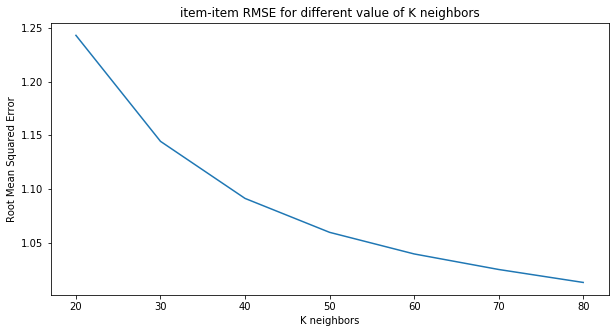

In [0]:
plt.figure(figsize=(10,5))
plt.plot(number_of_k,fold_average)
plt.ylabel("Root Mean Squared Error")
plt.title("item-item RMSE for different value of K neighbors")
plt.xlabel("K neighbors")
plt.show()

# Make recommendations

In [0]:
def userTopM(prediction, moviesDataset, userID, m):
    # Pick top K based on predicted rating
    userVector = prediction[userID-1,:]
    topM = nlargest(m, range(len(userVector)), userVector.take)
    namesTopM = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topM))
    return namesTopM
# define a topK function because users don't care if you have 10000 recommendation or not, they just care the topK that has the higest similarity!!!

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
userTopM(userSimPrediction, moviesDF, 350, 10) #change userSimPrediction to final model's prediction to get the recommendation

['Priest (1994)',
 'Tales from the Crypt Presents: Bordello of Blood (1996)',
 'Boxing Helena (1993)',
 'True Crime (1995)',
 'Stalingrad (1993)',
 'Audrey Rose (1977)',
 'Othello (1995)',
 'Bad Taste (1987)',
 'Trigger Effect, The (1996)',
 'Double vie de Véronique, La (Double Life of Veronique, The) (1991)']

In [0]:
userTopM(itemSimPrediction, moviesDF, 350, 10) #change userSimPrediction to final model's prediction to get the recommendation

['Misérables, Les (1995)',
 'Tales from the Hood (1995)',
 'Police Story 4: Project S (Chao ji ji hua) (1993)',
 "Daniel Defoe's Robinson Crusoe (1996)",
 'Tin Drum, The (Blechtrommel, Die) (1979)',
 'Fire on the Mountain (1996)',
 'Daylight (1996)',
 'Funeral, The (1996)',
 'Blue in the Face (1995)',
 'Before Sunrise (1995)']

In [0]:
pip install surprise

In [0]:
# the following code will perform item to itme collabroative filtering based on 
# surprise module.
# these par of code is modified from the online source: "Evaluation of Recommender
# Algorithms in Surprise on Yelp Ratings"
# coded by bmanohar from https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNWithMeans, KNNBasic
from surprise import SVD
from surprise import Dataset

In [0]:
data = Dataset.load_builtin('ml-100k')

In [0]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
knn = KNNWithMeans(sim_options = sim_options, k = 50)
knnbasic = KNNBasic(sim_options = sim_options, k = 50)

In [0]:
knnmeans_cv = cross_validate(knn, data, cv=5, n_jobs=5, verbose=False)
knnbasic_cv = cross_validate(knnbasic, data, cv=5, n_jobs=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)

In [0]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))

Algorithm	 RMSE		 MAE

KNN Basic 	 1.0244 	 0.81
KNN Means 	 0.9412 	 0.7398
SVD 		 0.9384 	 0.7401


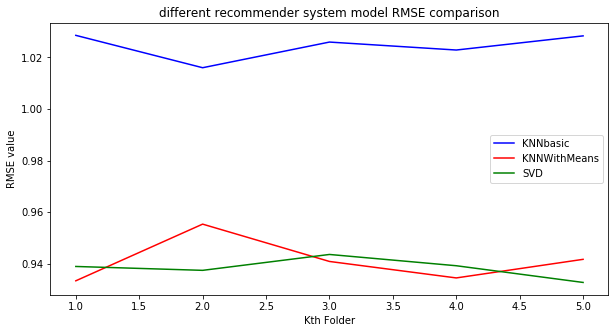

In [0]:
plt.figure(figsize=(10,5))
plt.plot(range(1,6),knnbasic_cv["test_rmse"], 'b', label = 'KNNbasic')
plt.plot(range(1,6),knnmeans_cv["test_rmse"], 'r', label = 'KNNWithMeans')
plt.plot(range(1,6),svd_cv["test_rmse"], 'g', label = 'SVD')
plt.legend()
plt.xlabel("Kth Folder")
plt.ylabel("RMSE value")
plt.title("different recommender system model RMSE comparison");
plt.show()